In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [3]:
true = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")
false = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")

In [4]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [9]:
true['category'] = 1
false['category'] = 0

In [10]:
df = pd.concat([true, false])


In [11]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


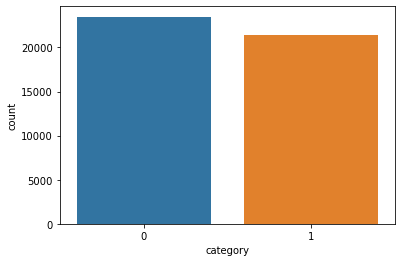

In [12]:
sns.countplot(df.category)

In [14]:
df.isna().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [15]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

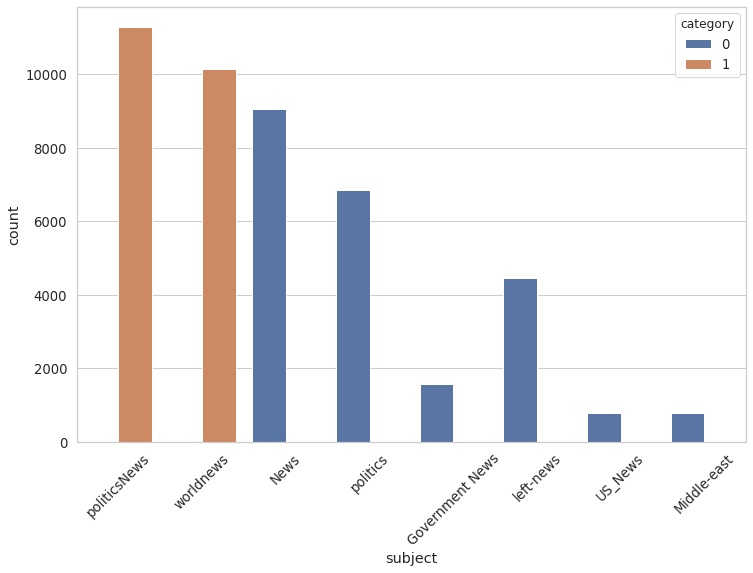

In [17]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=45)

In [18]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [19]:
df.head()

,text,category
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [23]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)


{'off', 'y', '?', '^', 'theirs', 'such', '`', "that'll", 'in', 'd', 'him', '{', 'above', 'you', 'who', 'both', 'few', '#', 'itself', "should've", '%', "you'll", 'with', "won't", 'these', 'didn', 'hers', 'having', 'mustn', '[', 'be', 'had', 'any', 'being', 'ain', 've', 'during', 'my', 'at', '!', 'into', 'under', ':', 'yourselves', '\\', "it's", 'wasn', "you've", 'the', 'is', 'or', 'can', 'until', '@', 's', 'couldn', 'why', 'doing', "shan't", 'an', '}', 'am', 'm', 'which', 'nor', 'them', 'no', 'too', 'what', "shouldn't", 'did', 'once', 'weren', 'shouldn', 'while', 'will', 'their', 'been', 'after', 'a', '"', 'not', "doesn't", 'that', 'ourselves', 'as', 'now', 'to', 'from', ';', 'because', 'themselves', '|', 'more', '-', 'your', 'so', 'all', 'by', 'll', 'yourself', 'over', 'it', 'wouldn', "weren't", 'were', '$', 'out', 'hadn', "needn't", 'has', 'ours', 'then', 'o', 'won', "couldn't", 'here', 're', 'hasn', 'other', 'are', '/', 'and', 'was', 'where', "wouldn't", 'when', "mustn't", 'whom', 't